In [1]:
import sys
sys.path.append('../src/')

from pandas import read_csv, to_datetime, concat
from numpy import where

In [2]:
holidays_data = read_csv('../data/holiday_17_18_19.csv - holiday_17_18_19.csv')
holidays = list(to_datetime(holidays_data["Date"], format='%d.%m.%Y'))
meteo_data = read_csv('../data/IST_meteo_data_2017_2018_2019.csv - IST_meteo_data_2017_2018_2019.csv')
building_data_2017 = read_csv('../data/IST_South_Tower_2017_Ene_Cons.csv')
building_data_2018 = read_csv('../data/IST_South_Tower_2018_Ene_Cons.csv')

# set index
meteo_data['yyyy-mm-dd hh:mm:ss'] = to_datetime(meteo_data['yyyy-mm-dd hh:mm:ss'], format='%Y-%m-%d %H:%M:%S')
meteo_data = meteo_data.set_index('yyyy-mm-dd hh:mm:ss')
building_data_2017['Date_start'] = to_datetime(building_data_2017['Date_start'], format='%d-%m-%Y %H:%M')
building_data_2018['Date_start'] = to_datetime(building_data_2018['Date_start'], format='%d-%m-%Y %H:%M')
building_data_2017 = building_data_2017.set_index('Date_start')
building_data_2018 = building_data_2018.set_index('Date_start')
building_data = concat([building_data_2017, building_data_2018])

# resample data and combine into one dataframe
meteo_data_resample = meteo_data.resample('H', closed='left', label='right')[
    'temp_C', 'HR', 'windSpeed_m/s', 'windGust_m/s', 'pres_mbar',
    'solarRad_W/m2', 'rain_mm/h'].mean()
meteo_data_resample["rain_day"] = meteo_data.resample('H', closed='left', label='right')['rain_day'].max()
df = building_data.join(meteo_data_resample)
df['holiday'] = where(df.index.to_period('D').astype('datetime64[ns]').isin(holidays), True, False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2017-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Power_kW       17520 non-null  float64
 1   temp_C         15383 non-null  float64
 2   HR             15383 non-null  float64
 3   windSpeed_m/s  15383 non-null  float64
 4   windGust_m/s   15383 non-null  float64
 5   pres_mbar      15383 non-null  float64
 6   solarRad_W/m2  15383 non-null  float64
 7   rain_mm/h      15383 non-null  float64
 8   rain_day       15383 non-null  float64
 9   holiday        17520 non-null  bool   
dtypes: bool(1), float64(9)
memory usage: 1.4 MB


In [4]:
df.head()

,Power_kW,temp_C,HR,windSpeed_m/s,windGust_m/s,pres_mbar,solarRad_W/m2,rain_mm/h,rain_day,holiday
2017-01-01 00:00:00,100.810001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2017-01-01 01:00:00,99.054135,8.532500,74.966667,2.344500,3.270750,1029.000000,1.355083,0.0,0.0,True
2017-01-01 02:00:00,98.539567,7.930000,76.308333,2.692417,3.480333,1028.166667,1.477333,0.0,0.0,True
2017-01-01 03:00:00,101.435784,7.263417,80.275000,3.300250,4.067167,1028.000000,1.415083,0.0,0.0,True
2017-01-01 04:00:00,98.481664,6.831333,81.333333,3.534333,4.423583,1028.000000,1.542000,0.0,0.0,True


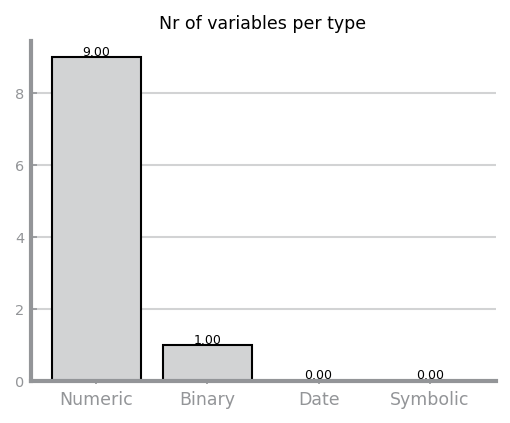

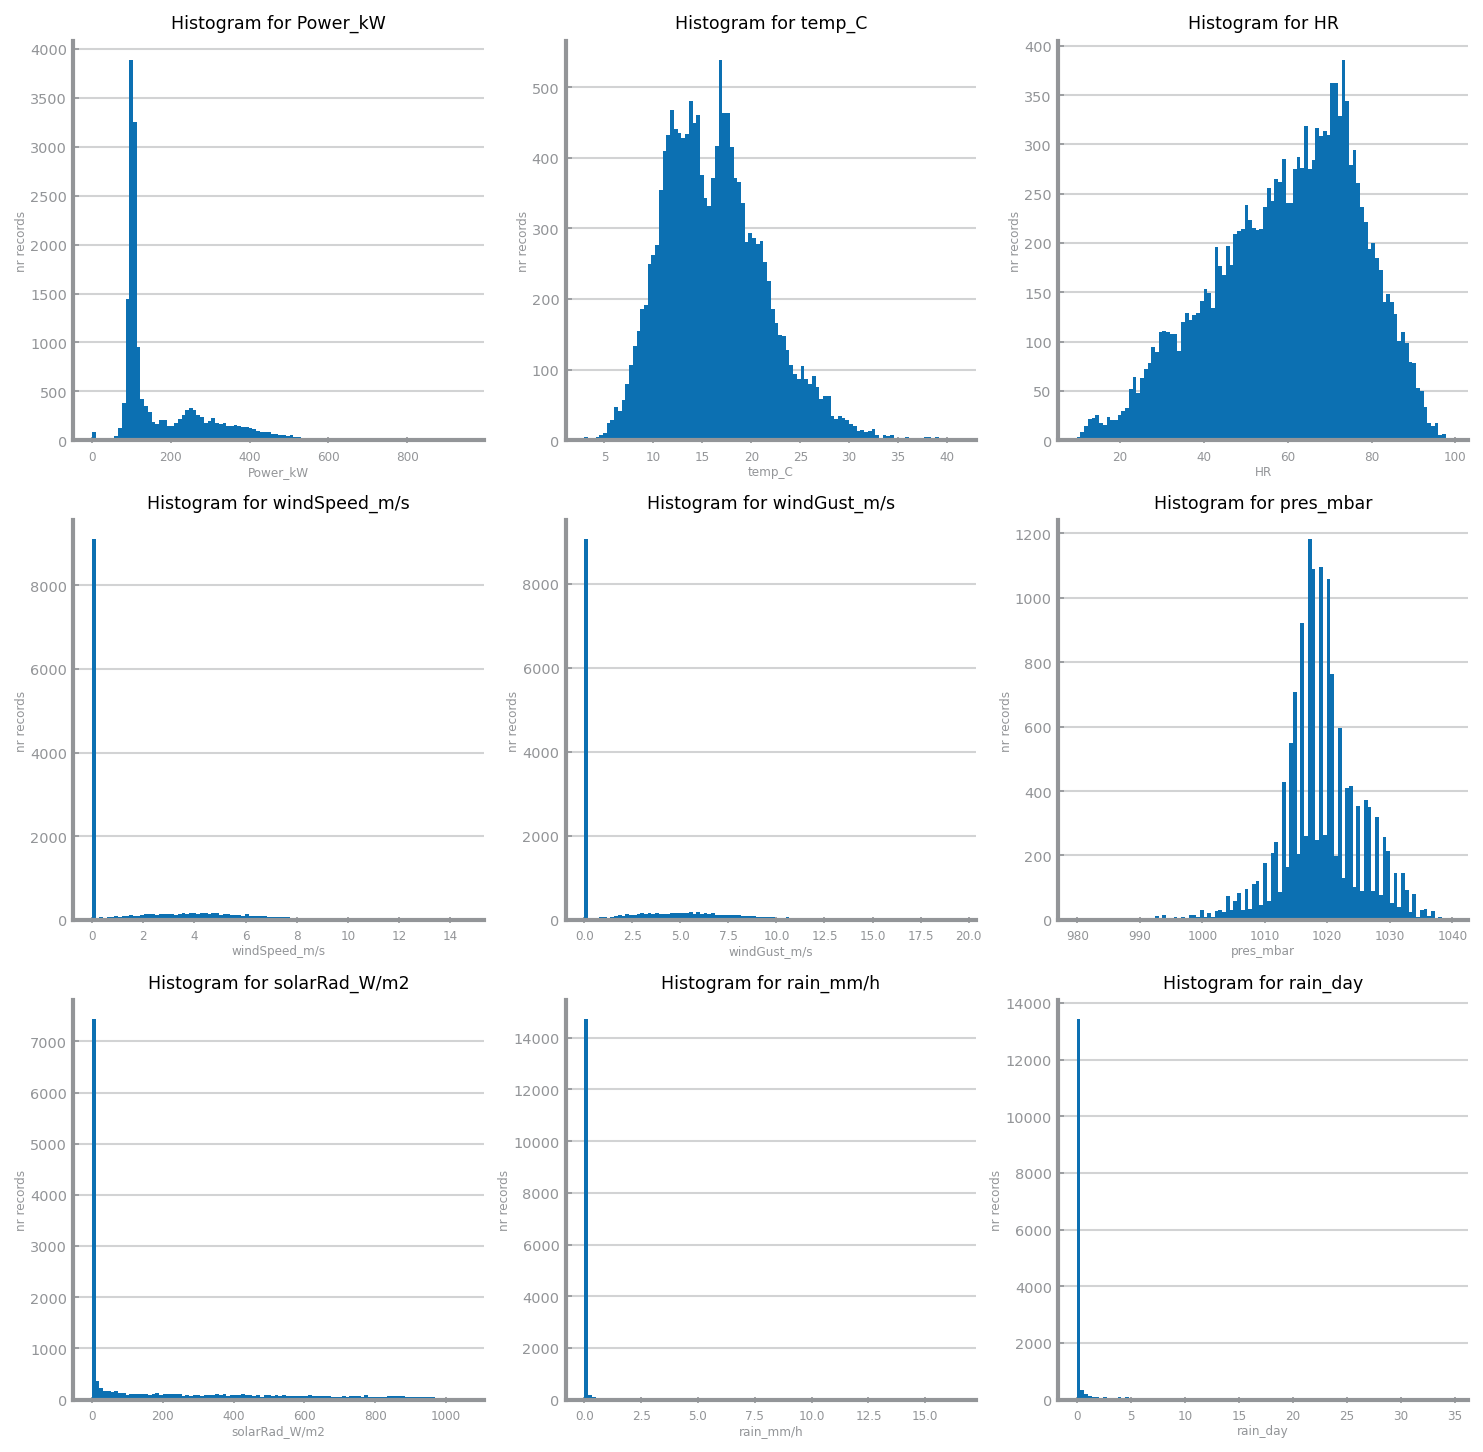

In [5]:
from ds_tools.profiling import show_variable_types, show_histograms_numeric
show_variable_types(df)
show_histograms_numeric(df)